<h1>将敏感性分析应用于WOFOST模型</h1>

敏感性分析是研究数学模型或系统（数值型或其他类型）输出的不确定性如何归因于其输入中的不同不确定性来源（见维基百科：<a href="https://en.wikipedia.org/wiki/Sensitivity_analysis">https://en.wikipedia.org/wiki/Sensitivity_analysis</a>）。每个输入的敏感性通常由一个数值来表示，该数值被称为敏感性指数。

在本笔记本中，我们将演示如何针对WOFOST模型的多个重要参数进行敏感性分析。WOFOST模型存在的问题在于，依据模型是否接近某些阈值的情况，其敏感性会因不同作物和不同地区而有所差异。因此，通过本笔记本提供敏感性分析的一般性指导原则，要比给出一组预先定义好的敏感参数更有用。

本笔记本的一个局限在于，它仅适用于WOFOST模型中的标量参数。WOFOST模型还有许多表格参数，这些参数是依据发育阶段或温度来定义的。使用本笔记本中采用的方法无法对这些参数的敏感性进行恰当的分析。

下文将针对荷兰的甜菜作物运行WOFOST模型，然后进行敏感性分析。敏感性分析的目标变量是贮藏器官总重量（TWSO），它代表着作物产量。不过，也可以选择其他变量，比如作物总生物量或最大叶面积指数。

*史蒂文·胡克（Steven Hoek）、阿拉德·德·威特（Allard de Wit），瓦赫宁根环境科学研究所，2020年6月*

## 运行本笔记本所需的依赖项
运行本笔记本需要安装以下软件包：
- [PCSE](https://pcse.readthedocs.io/en/stable/)及其依赖项（numpy、pandas、PyYAML、SQLAlchemy等）
- [SAlib](https://salib.readthedocs.io/en/latest/)
- [IPython](http://ipython.org/)
- [tqdm](https://tqdm.github.io/)（用于显示进度条） 

In [2]:
import sys, os.path
# 导入系统相关模块（sys）和用于处理文件路径相关操作的模块（os.path），可用于获取系统信息、操作文件路径等功能
import yaml
# 导入yaml模块，用于读取和解析yaml格式的配置文件，在本代码中可能用于加载模型相关的配置数据
import numpy as np
# 导入numpy库，用于进行数值计算，提供了多维数组等数据结构以及大量数学函数，是数据处理和科学计算常用的库
import pandas as pd
# 导入pandas库，用于数据处理和分析，方便对表格型数据进行操作，例如读取、处理、展示等
from tqdm import tqdm
# 从tqdm库中导入tqdm，tqdm是一个用于在循环等操作中显示进度条的工具，方便查看代码执行进度
from SALib.sample import saltelli
# 从SALib库的sample模块中导入saltelli函数，SALib用于进行敏感性分析，saltelli函数通常用于生成特定抽样方法（Saltelli抽样）的样本数据
# from SALib.analyze import sobol
# 从SALib库的analyze模块中导入sobol函数，用于对抽样样本进行分析，计算基于Sobol方法的敏感性指标等
import matplotlib.pyplot as plt
# 导入matplotlib的pyplot模块，用于绘制各种可视化图表，如折线图、柱状图等，方便展示数据和分析结果
from IPython.display import display
# 从IPython的display模块中导入display函数，用于在IPython环境中更好地展示各种数据对象（如数据框等）的显示效果
pd.set_option("display.max_rows", None)
# 设置pandas数据框显示时的最大行数为无限制，默认情况下可能会对显示行数有一定限制，这样可完整展示较多数据
pd.set_option("display.max_colwidth", 250)
# 设置pandas数据框显示时每列的最大宽度为250字符，避免列内容显示不全或显示格式不佳的情况

import pcse
# 导入pcse（Python Crop Simulation Environment）库，这是用于作物模拟的环境库，包含了多种作物模拟模型等功能
from pcse.models import Wofost72_PP,Wofost72_WLP_FD,Wofost72_WLP_CWB,Wofost73_WLP_CWB,Wofost81_NWLP_MLWB_SNOMIN
# 从pcse的models模块中导入Wofost72_PP类，这应该是WOFOST 72版本的某种作物生产潜力相关模型类，用于具体的作物生长模拟
from pcse.base import ParameterProvider
# 从pcse的base模块中导入ParameterProvider类，可能用于提供模型运行所需的各种参数
from pcse.input import NASAPowerWeatherDataProvider, WOFOST81SiteDataProvider_SNOMIN  
# 从pcse的input模块中导入NASAPowerWeatherDataProvider类，用于获取NASA提供的气象数据作为模型输入
from pcse.input import YAMLCropDataProvider, WOFOST72SiteDataProvider
# 分别导入用于提供作物数据（从yaml文件读取）的YAMLCropDataProvider类和与WOFOST 72站点相关数据的WOFOST72SiteDataProvider类
from pcse.input import  DummySoilDataProvider
# 从pcse的util模块中导入DummySoilDataProvider类，可能用于提供模拟所需的土壤相关数据（也许是简单的虚拟数据示例等）
from progressbar import printProgressBar
# 从progressbar库中导入printProgressBar函数，也是用于显示进度相关信息的功能（可能和tqdm功能类似但不同实现）

print("This notebook was built with:")
# 输出提示信息，表示接下来要展示构建此笔记本（可能是代码运行环境相关的记录等）所使用的相关版本信息
print(f"python version: {sys.version}")
# 输出当前Python的版本信息，通过sys.version获取并格式化输出，方便查看代码运行的Python环境版本
print(f"PCSE version: {pcse.__version__}")
# 输出PCSE库的版本信息，通过访问pcse库自身的版本属性__version__获取并展示，便于确认使用的PCSE具体版本
# 从pathlib库中导入Path类，用于更方便地操作文件和目录路径
from pathlib import Path  
# 该目录可能用于存放与WOFOST 8.1相关的数据文件等
data_dir = Path.cwd() / "data" / "wofost81"  
# 将data_dir转换为字符串形式，并添加到Python的模块搜索路径中，
# 这样Python解释器就能在这个目录及其子目录下查找可能需要导入的模块或包等内容
sys.path.append(str(data_dir))  

This notebook was built with:
python version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
PCSE version: 6.0.8


## WOFOST参数
下表概述了与潜在产量情况相关的重要的WOFOST标量参数。

In [3]:
df = pd.read_excel("ScalarParametersOfWofost-Potential.xlsx")
# 使用pandas库的read_excel函数读取指定路径下名为"ScalarParametersOfWofost-Potential.xlsx"的Excel文件，
# 将文件中的数据读取到一个DataFrame（数据框）对象中，并赋值给变量df，后续可以对这个数据框进行各种数据处理和分析操作。

display(df)
# 使用之前从IPython.display模块导入的display函数，将读取到的DataFrame（即df变量所代表的数据框）进行展示，
# 按照之前设置的pandas显示选项（如最大行数、列宽等）在当前运行环境（比如IPython Notebook等）中友好地呈现数据内容，方便查看数据详情。

,Name,Typical Value,Category,Description,Unit
0,CFET,1.000,Water use,correction factor for evapotranspiration,-
1,CVL,0.720,Conversion of assimilates into biomass,efficiency conversion of assimilates into leaf dry matter,kg / kg
2,CVO,0.820,Conversion of assimilates into biomass,efficiency conversion of assimilates into storage organ dry matter,kg / kg
3,CVR,0.720,Conversion of assimilates into biomass,efficiency conversion of assimilates into root dry matter,kg / kg
4,CVS,0.690,Conversion of assimilates into biomass,efficiency conversion of assimilates into stem dry matter,kg / kg
5,DLC,16.000,Phenology,critical day length for development (lower threshold),hours
6,DLO,8.000,Phenology,optimum day length for development,hours
7,PERDL,0.030,Death rates,max. relative death rate of leaves due to water stress,-
8,Q10,2.000,Maintenance respiration,increase of the respiration rate per 10 °C temperature increase,-
9,RDI,10.000,Water use,initial rooting depth,cm


## 作物及种植地点设置
以下将使用标准数据针对荷兰的甜菜运行WOFOST模型。你可以随意针对不同的作物和/或不同的种植地点开展此项敏感性分析。

In [4]:
# Define location, crop and season
# 以下代码用于定义模拟所涉及的地理位置、作物相关信息以及生长季节等关键参数，方便后续配置WOFOST模型

latitude = 52.0
# 定义地理纬度，此处设置为52.0，代表模拟作物生长地点所在的纬度值，单位应为度，这里设定的是荷兰大致所处纬度范围的某个纬度值，用于提供地理位置信息给模型

longitude = 5.0
# 定义地理经度，设置为5.0，代表模拟作物生长地点所在的经度值，单位为度，同样是荷兰大致所在经度范围的某个经度值，与纬度一起确定具体地理位置，供模型使用

crop_name = 'sugarbeet'
# 定义作物名称，将作物名称设置为'sugarbeet'，表明此次模拟的对象是甜菜，模型会依据此名称去获取对应作物相关的特性参数等信息来进行生长模拟

variety_name = 'Sugarbeet_601'
# 定义作物品种名称，这里指定为'Sugarbeet_601'，不同品种的作物在生长特性等方面可能存在差异，模型可以根据此品种名称进一步获取更细化、精准的品种相关参数用于模拟

campaign_start_date = '2006-03-01'
# 定义作物生长季开始日期，设置为'2006-01-01'，它表示整个模拟的起始时间点，从这个时间开始考虑气象、土壤等因素对作物生长的影响，格式遵循常见的年-月-日形式

emergence_date = "2006-03-31"
# 定义作物出苗日期，设置为'2006-03-31'，该日期标志着作物从播种到开始出苗的时间点，对于模型中模拟作物早期生长阶段等相关过程是个重要的时间参考

harvest_date = "2006-10-20"
# 定义作物收获日期，设定为'2006-10-20'，意味着模拟到这个时间点结束，代表作物生长周期结束的时间，模型依据此日期来汇总最终的生长结果等

max_duration = 300
# 定义作物生长最大持续天数，设置为300天，这是一个限制值，用于防止在某些特殊情况下作物模拟时长超出合理范围，确保模拟过程在合理的时间框架内进行，即便其他相关日期等设置出现异常也不至于无限制运行下去。

## 构建种植日历

In [5]:
# Here we define the agromanagement for sugar beet
# 此处我们为甜菜定义农业管理相关的信息，这些信息通常包含作物种植的时间安排、生长阶段起止等内容，用于后续配置作物生长模拟模型。

agro_yaml = """
- {start}:
    CropCalendar:
        crop_name: {cname}
        variety_name: {vname}
        crop_start_date: {startdate}
        crop_start_type: emergence
        crop_end_date: {enddate}
        crop_end_type: harvest
        max_duration: {maxdur}
    TimedEvents: null
    StateEvents: null
""".format(cname=crop_name, vname=variety_name, 
           start=campaign_start_date, startdate=emergence_date, 
           enddate=harvest_date, maxdur=max_duration)
# 使用三引号定义了一个包含作物种植日历等农业管理信息的字符串模板（agro_yaml），并通过.format()方法将之前定义好的变量（如作物名称、品种名称、起止日期、最大持续天数等）的值填充进去，
# 这样就构建出了符合特定格式要求的包含甜菜种植相关详细时间安排和管理信息的字符串内容，后续可通过解析该字符串来获取相应的配置信息用于模型。

agro = yaml.safe_load(agro_yaml)
# 使用yaml模块的safe_load函数对前面构建好的包含农业管理信息的字符串（agro_yaml）进行安全加载和解析，将其转换为Python中的对应数据结构（比如字典、列表等，具体取决于yaml内容格式），
# 并赋值给变量agro，以便后续将这些解析后的配置信息传递给作物生长模拟模型使用。

print(agro_yaml)
# 输出前面构建好的包含农业管理信息的字符串（agro_yaml）的内容，主要用于查看字符串格式是否正确、填充的变量值是否符合预期等，方便调试和确认配置信息的准确性。


- 2006-03-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_601
        crop_start_date: 2006-03-31
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null



## 获取气象输入数据与模型参数

In [6]:
# Weather data for Netherlands
# 以下代码用于获取荷兰地区的气象数据，气象数据是作物生长模拟模型的重要输入之一，会影响作物生长过程中的诸多环节，如光合作用、蒸腾作用等。

# wdp = NASAPowerWeatherDataProvider(latitude=latitude, longitude=longitude)
# 原本这行代码可能是计划使用NASA提供的基于经纬度获取气象数据的方式来获取气象数据，但被注释掉了，也许是打算采用其他数据源或方式获取气象数据。

from pcse.input import ExcelWeatherDataProvider
# from pathlib import Path
# 在刚才构建的data_dir基础上，进一步拼接"input"目录名，构建出表示输入文件所在目录的路径对象，
# 预计后续用于存放模拟的输入数据，比如作物、土壤等相关参数文件
input_dir = data_dir / "input"  
# 从pcse库的input模块中导入ExcelWeatherDataProvider类，用于从Excel文件中读取气象数据；导入Path类用于处理文件路径相关操作，方便准确地定位到气象数据文件所在位置。
# 在input_dir基础上再拼接"crop"目录名，构建出专门存放作物相关输入文件的目录路径对象，
# 可能存放作物品种特性、生长参数等特定于作物的数据文件
# crop_dir = input_dir / "crop"  

data_dir = Path.cwd() / "data"  #/ "wofost81"
# 创建一个代表数据目录的路径对象，Path.cwd()获取当前工作目录，然后拼接上"data"文件夹名称（后面注释掉的"wofost81"可能是原本计划进一步深入的子目录结构，暂未使用），
# 该目录可能用于存放模型相关的各种数据文件，比如气象数据、作物数据等。

# input_dir = data_dir / "input"
# 同样这行被注释掉了，可能原本计划进一步定义一个输入数据的子目录路径，不过目前未启用这个路径定义。

weather_dir = data_dir / "meteo"
# 创建代表气象数据所在目录的路径对象，在之前定义的"data"目录基础上拼接"meteo"文件夹名称，表明气象数据文件存放在这个目录下。

weather_fname = weather_dir / "nl1.xlsx"
# 构建具体气象数据文件的完整路径对象，在气象数据目录（weather_dir）下拼接具体的文件名"nl1.xlsx"，这个Excel文件应该包含了荷兰地区的气象观测数据，用于模型输入。

wdp = ExcelWeatherDataProvider(weather_fname)
# 使用ExcelWeatherDataProvider类实例化一个对象wdp，通过传入气象数据文件的路径（weather_fname），以便后续可以从这个Excel文件中读取气象数据提供给作物生长模拟模型。

# Parameter sets for crop, soil and site
# 以下代码用于获取作物、土壤和种植地点相关的各种参数，这些参数共同决定了作物在特定环境下的生长特性和模拟结果。

# Standard crop parameter library
cropd = YAMLCropDataProvider()
# df_1 = pd.DataFrame(cropd)  
# # print(df_1)
# # df_1.to_csv()
# output_dir = data_dir / "output"  
# # 通过output_dir（应该是之前定义好的表示输出文件目录的变量）与 "example_output.xlsx" 进行路径拼接，
# # 构建出输出文件的完整路径，并将其赋值给output_fp变量，用于明确最终输出结果要保存的Excel文件位置。
# output_fp = output_dir / "crop_dict.xlsx"  
# # 调用DataFrame对象（即df_output）的to_excel()方法，将模型的输出结果以Excel文件的形式保存到output_fp指定的文件路径下，
# # 这样就可以方便地查看和进一步分析模型模拟所得到的各项数据了，比如查看不同时间步长下作物的生长指标、土壤水分含量等数据情况。
# df_1.to_csv(output_fp)  

# 实例化一个YAMLCropDataProvider类的对象cropd，用于从yaml格式的文件中获取标准的作物参数，这些参数涵盖了作物本身的各种生物学特性、生长需求等信息，为模型提供作物相关的基础数据。

# We don't need soil for potential production, so we use dummy values
soild = DummySoilDataProvider()


# 加载站点数据 CO2=360. Value for parameter SMFCF missing SMFCF=0.2

# 由于在潜在产量模拟场景下可能不需要详细准确的土壤实际数据（也许重点关注理想条件下的产量情况），所以实例化一个DummySoilDataProvider类的对象soild，
# 它可能会提供一些默认的、虚拟的土壤相关数据作为模型中土壤部分的输入，简化了土壤因素在此次模拟中的影响考虑。

# Some site parameters
# sited ={} #WOFOST72SiteDataProvider(WAV=50, CO2=360.)
# 加载站点数据 CO2=360. Value for parameter SMFCF missing SMFCF=0.2

sited = WOFOST72SiteDataProvider(WAV=50, )
# 原本这里可能计划使用WOFOST72SiteDataProvider类来实例化一个对象并传入一些站点相关参数（如WAV=50，CO2=360等，具体含义与模型相关），但目前只是定义了一个空字典sited，
# 可能后续会以其他方式补充站点相关参数，或者在当前模拟场景下某些站点参数暂不做重点考虑。


# Retrieve all parameters in the form of a single object. 
# In order to see all parameters for the selected crop already, we
# synchronise data provider cropd with the crop/variety: 
firstkey = list(agro[0])[0]
# 获取agro列表中第一个元素（应该是包含农业管理信息的字典结构）的第一个键，这个键可能对应着特定的时间节点或者管理阶段相关的信息，用于后续提取作物种植日历相关内容。

cropcalendar = agro[0][firstkey]['CropCalendar'] 
# 通过前面获取的键，从agro数据结构中提取出作物种植日历（CropCalendar）相关的详细信息，这些信息包含了作物名称、品种、生长起止时间等关键内容，对于后续配置模型很重要。

cropd.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])
# 使用从作物种植日历中获取的作物名称和品种名称，调用cropd（YAMLCropDataProvider对象）的set_active_crop方法，使得作物参数数据提供者（cropd）能够聚焦于当前模拟所选定的作物及其品种，
# 确保获取到的作物参数是符合实际模拟需求的准确数据。

params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)
# 实例化一个ParameterProvider类的对象params，将前面获取到的作物参数数据提供者（cropd）、站点参数（sited）以及土壤参数（soild）作为参数传入，
# 把所有这些相关参数整合到一个对象中，方便后续整体传递给作物生长模拟模型使用，使得模型可以依据这些完整的参数集合进行作物生长模拟运算。

## 定义分析内容
敏感性分析意味着我们要对模型参数稍作变动，以了解模型对于这些参数值的不准确性/变化有多敏感。我们重点关注模型参数的变化，而非诸如降雨量或温度等驱动变量的不准确性。

在下文中，我们会为各参数定义取值区间。有必要了解参数的实际合理取值是什么，而这些取值往往因作物种类和地区的不同而有所差异。 

In [7]:
# Define the target variable
# 定义目标变量，这个变量通常是我们在敏感性分析中重点关注其变化情况的量，会随着模型参数的改变而产生相应变化，进而用于评估模型对各参数的敏感程度。
target_variable = "TWSO"
# 将目标变量设置为 "TWSO"，从上下文来看，它可能代表着某种与作物产量相关的指标（比如贮藏器官总重量之类的，具体需结合完整模型背景确定），后续会观察它在参数变动时如何变化。

# For each scalar parameter, determine a sensible interval 
# 针对每个标量参数，确定一个合理的取值区间。在敏感性分析中，通过改变参数在这个区间内的值，来查看对目标变量以及整个模型输出的影响，合理区间的设定需要结合实际情况考虑参数的可能取值范围。

problem_yaml = """
    num_vars: 5
    names: 
    - TSUM1
    - TSUM2
    - SPAN
    - Q10
    - TDWI
    bounds:
    - [500, 800]
    - [1200, 1600]
    - [28, 37]
    - [1.8, 2.2]
    - [0.4, 0.6]
"""
# 使用三引号定义了一个包含参数信息的yaml格式的字符串（problem_yaml），这里定义了要进行敏感性分析的标量参数相关内容。
# num_vars表示参数的数量，此处为5个；names列出了各个参数的名称（TSUM1、TSUM2、SPAN、Q10、TDWI，具体含义与WOFOST模型相关）；
# bounds则对应地给出了每个参数的取值区间，例如TSUM1的取值区间是[500, 800]，这些区间设定是基于对这些参数在实际作物及所在地区情况下合理取值范围的考量。

problem = yaml.safe_load(problem_yaml)
# 使用yaml模块的safe_load函数对前面定义的yaml格式字符串（problem_yaml）进行安全加载和解析，将其转换为Python中合适的数据结构（可能是字典等形式），
# 并赋值给变量problem，以便后续基于这个解析好的参数信息结构来进行抽样以及敏感性分析等操作，它包含了敏感性分析所需的参数数量、名称和取值区间等关键信息。

## 一阶和二阶敏感度
在进行敏感性分析时，我们可能会计算一阶和二阶敏感度。如果参数数量较多，计算二阶敏感度可能需要运行大量的模型。

在本示例中，我们使用Saltelli抽样器对参数值的多种组合进行抽样，并将推导得出一阶和二阶敏感度。变量“nsamples”表示要生成的样本数量，该数值越高，对敏感度的估算就越准确，但会增加计算时间。 

In [8]:
from SALib.sample import sobol as sb
# 从SALib库的sample模块中导入sobol函数，这个函数通常用于进行基于特定抽样方法（比如Sobol序列抽样相关方法）的抽样操作，
# 目的是生成模型参数的不同取值组合，以便后续通过运行模型并观察结果变化来进行敏感性分析。

import math
# 导入Python的数学计算库math，用于进行一些数学相关的操作，比如下面会用到的计算幂次方的操作，在设置样本数量等情况时可能会用到数学运算。

# from SALib.analyze import sobol
# 这行代码被注释掉了，原本可能计划从SALib库的analyze模块中导入sobol函数（与前面导入的用于抽样的sobol函数虽然同名但功能不同，一个用于分析），
# 用于后续对抽样结果进行敏感性分析相关的计算操作，但目前暂未启用这个导入（也许后续会取消注释启用，或者使用其他方式进行分析）。

calc_second_order = True
# 设置一个布尔类型的变量calc_second_order为True，表示在抽样及后续敏感性分析过程中要计算二阶敏感度。如果设置为False，则只计算一阶敏感度，
# 二阶敏感度计算相对更复杂且通常在参数较多时会增加很多计算量，但能提供更全面的敏感度信息。

nsamples = int(math.pow (2,2)) #-1
# 使用math库的pow函数计算8的2次方，将结果赋值给nsamples变量，这里是在确定要生成的样本数量，通过计算得到的64表示将生成64组不同的参数取值组合，
# 更多的样本数量一般能让敏感度估算更准确，但同时也会增加计算时间成本。
# nsamples=50
# print(nsamples)
# 这行代码被注释掉了，原本的作用是输出nsamples变量的值（也就是计算出的样本数量64），用于查看或调试样本数量设置是否符合预期等情况，不过目前暂不执行这个输出操作。

# # 生成样本
# nsamples = 60  # 样本数量

# paramsets = saltelli.sample(problem, nsamples, calc_second_order=calc_second_order) 
# 这几行代码被注释掉了，从代码上下文推测，原本可能是另一种生成样本的方式或者是之前尝试过的代码逻辑，其中先是再次定义了样本数量为64（与前面计算结果重复了，可能是不同阶段的写法），
# 接着调用self._random方法（不过这里不清楚self具体指代什么，可能是某个类实例对象的方法）进行某种随机抽样相关操作，最后使用saltelli.sample方法根据给定的问题参数（problem）、
# 样本数量（nsamples）以及是否计算二阶敏感度（calc_second_order）的设置来生成参数集（paramsets），不过目前采用了下面启用的那行代码来生成样本。

# 使用 sobol.sample 方法生成样本集
paramsets = sb.sample(problem, nsamples, calc_second_order=calc_second_order)
# 使用前面导入的sobol函数的sample方法，根据给定的问题参数结构（problem，包含了参数数量、名称、取值区间等信息）以及设定的样本数量（nsamples）和是否计算二阶敏感度的要求，
# 生成相应的参数集（paramsets），也就是生成多组不同的参数取值组合，每组组合对应着不同的模型输入情况，后续可通过将这些参数组合依次代入模型运行来观察模型输出的变化情况，用于敏感性分析。


print("We are going to do %s simulations" % len(paramsets))
# 输出提示信息，告知将要进行的模拟次数，模拟次数由生成的参数集（paramsets）的长度决定，也就是前面生成的不同参数取值组合的数量，让使用者了解后续模型运行的大致规模。

We are going to do 48 simulations


In [9]:
# 定义一个列表Thickness，用于表示各土壤层的厚度，列表中的每个元素依次对应每一层土壤的厚度值（单位为厘米），
# 这里设定了四层土壤，厚度值分别为25厘米、15厘米、20厘米、60厘米，后续会作为土层特性参数提供给相关模块（如SNOMIN等）使用
Thickness = [25., 15., 20., 60]  
# 通过获取Thickness列表的长度来确定土壤的层数，这样后续在涉及循环遍历各土壤层等操作时，可以方便地依据此变量知晓层数信息
nlayers = len(Thickness)  

# 定义一个列表CNRatioSOMI，用于存放各土壤层中有机质的碳氮比（单位为千克碳·千克⁻¹氮），
# 列表中的元素依次对应各层土壤的该比值，这里四层土壤的碳氮比分别设定为17、25、25、25
CNRatioSOMI = [17., 25., 25., 25.]  
# 定义一个列表CRAIRC，用于表示各土壤层的临界空气含量（单位为立方米空气·立方米土壤⁻¹），
# 各元素对应各层土壤的临界空气含量值，此处四层土壤的临界空气含量均设定为0.09
CRAIRC = [0.09, 0.09, 0.09, 0.09]  
# 定义一个列表FSOMI，用于存放各土壤层中土壤初始有机质所占的比例（单位为千克有机质·千克⁻¹土壤），
# 列表元素依次对应各层该比例的值，四层土壤的初始有机质占比分别设定为0.05、0.02、0.01、0
FSOMI = [0.05, 0.02, 0.01, 0.]  
# 定义一个列表RHOD，用于表示各土壤层的土壤容重（单位为千克土壤·立方米土壤⁻¹），
# 各元素对应各层土壤的容重值，四层土壤的容重分别设定为1.375、1.576、1.633、1.672
RHOD = [1.375, 1.576, 1.633, 1.672]  
# 定义一个列表SMW（从变量名推测可能是和土壤含水量相关的一个临时变量，可能后续还会进一步处理或者使用场景特定），
# 这里暂时将四层土壤对应的该值都设为0.1，具体单位等含义需结合更详细的程序上下文确定，可能和土壤含水量有关的某个中间量
SMW = [0.1, 0.1, 0.1, 0.1]  
# 定义一个列表Soil_pH，用于存放各土壤层的土壤酸碱度（单位为对数（摩尔氢离子·升⁻¹）），
# 列表元素依次对应各层土壤的酸碱度值，四层土壤的酸碱度分别设定为4.8、4.5、4.5、4.7
Soil_pH = [4.8, 4.5, 4.5, 4.7]  
# 定义一个列表alpha（对应范格努钦参数中的阿尔法），列表中的每个元素依次代表每一层土壤对应的阿尔法值，
# 这些值将用于后续结合其他范格努钦参数来计算土壤含水量（SM）和水力传导率（COND）随pF值变化的相关数值，
# 此处为四层土壤分别设定了相应的alpha值，单位等具体物理含义需结合范格努钦模型相关知识来确定。
alpha = [0.02164487, 0.01608317, 0.01608317, 0.01598691]  
# 定义一个列表k_sat（对应范格努钦参数中的饱和水力传导率），单位为厘米/天（cm d-1），
# 列表元素依次是各层土壤的饱和水力传导率值，用于描述每层土壤在饱和状态下导水能力的强弱，
# 四层土壤分别设定了对应的k_sat值，后续参与到相关水力特性相关计算中。
k_sat = [83.24163508, 22.76175599, 22.76175599, 22.32215442]  
# 定义一个列表labda（对应范格努钦参数中的兰姆达），每个元素对应各层土壤的兰姆达值，
# 同样该参数会与其他范格努钦参数共同作用，辅助计算土壤水力特性相关的一些函数数值，四层土壤各自有对应的labda值设定在此列表中。
labda = [7.20207718, 2.43966226, 2.43966226, 2.8679672]  
# 定义一个列表n，对应范格努钦参数中的n值，列表内各元素按顺序表示各层土壤的n值，
# 在依据范格努钦模型计算土壤含水量、水力传导率随pF变化等情况时，该参数起着重要作用，四层土壤分别有对应的n值设定在此。
n = [1.34877009, 1.52441823, 1.52441823, 2.16275113]  
# 定义一个列表theta_r（对应范格努钦参数中的残余土壤含水量），每个元素表示每层土壤的残余土壤含水量，
# 即土壤在经过排水等过程后剩余的最小含水量，四层土壤分别设定了对应的theta_r值，其会参与到相关水力特性计算当中。
theta_r = [0.02, 0.02, 0.02, 0.01]  
# 定义一个列表theta_s（对应范格努钦参数中的饱和土壤含水量），各元素依次代表各层土壤达到饱和状态时的含水量，
# 用于衡量每层土壤在饱和情况下所能容纳水分的量，四层土壤各自设定了对应的theta_s值，在后续水力特性相关计算中会用到该参数。
theta_s = [0.43387803, 0.3870639, 0.3870639, 0.36584689]  

# 定义一个列表pFs，用于存储一系列的pF值。这些pF值将作为自变量，
# 后续会基于它们以及前面定义的范格努钦（Van Genuchten）参数等来计算相应的土壤含水量（SMfromPF）和水力传导率（CONDfromPF），
# 从而构建起描述土壤水力特性随pF值变化的函数关系，每个元素代表一个具体的pF取值。
pFs = [-1.0, 1.0, 1.3, 1.7, 2.0, 2.3, 2.4, 2.7, 3.0, 3.3, 3.7, 4.0, 4.2, 6.0]

# 从名为vangenuchten的模块中导入三个函数，分别是calculate_water_potential_form_pf（可能用于根据pF值计算水势相关内容，此处未直接使用）、
# calculate_soil_moisture_content（用于根据给定的pF值以及对应土层的相关范格努钦参数来计算土壤含水量）、
# calculate_log10_hydraulic_conductivity（用于依据给定的pF值和对应土层的相关范格努钦参数来计算以10为底的对数形式的水力传导率）
from vangenuchten import calculate_water_potential_form_pf, calculate_soil_moisture_content, calculate_log10_hydraulic_conductivity  

# 创建一个空列表CONDfromPF_perlayer，用于存储每一层土壤的基于pF值的水力传导率（CONDfromPF）数据，
# 后续会将每层土壤计算得到的对应数据添加到这个列表中，最终形成一个包含各层土壤相关数据的列表结构。
CONDfromPF_perlayer = []  
# 创建一个空列表SMfromPF_perlayer，目的是用来存放每一层土壤的基于pF值的土壤含水量（SMfromPF）数据，
# 之后会把每层土壤经过计算得出的相应数据依次添加进来，以构建起包含各层土壤该数据的列表。
SMfromPF_perlayer = []  

# 开始循环遍历每一层土壤，这里的nlayers是之前通过土层厚度列表Thickness的长度获取到的，表示土壤的总层数，
# 通过这个循环，可以针对每一层土壤分别进行后续的计算操作，以构建每层对应的SMfromPF和CONDfromPF数据。
for i in range(nlayers):  
    # 在每一层土壤的循环内部，创建一个空列表CONDfromPF，用于临时存储当前层土壤在不同pF值下计算得到的基于pF值的水力传导率数据，
    # 后续在内部的小循环中会不断添加数据进来，然后整体添加到CONDfromPF_perlayer列表中。
    CONDfromPF = []  
    # 同样在每一层土壤的循环内，创建一个空列表SMfromPF，用于临时存放当前层土壤在不同pF值下计算得出的基于pF值的土壤含水量数据，
    # 之后会在小循环里逐步添加相应数据，最后添加到SMfromPF_perlayer列表中。
    SMfromPF = []  
    # 开始内层循环，使用enumerate函数同时获取索引j和对应元素pF，这里的pFs是之前定义的包含多个pF值的列表，
    # 通过这个循环可以依次取出每个pF值，用于针对当前层土壤（由外层循环的i决定）计算相应的土壤含水量和水力传导率。
    for j, pF in enumerate(pFs):  
        # 调用calculate_soil_moisture_content函数，传入当前的pF值以及当前层土壤（由i指定）对应的范格努钦参数alpha、n、theta_r、theta_s，
        # 计算出当前pF值下的土壤含水量，并将结果赋值给变量r，该函数的作用就是依据相关参数和pF值来确定土壤含水量的具体数值。
        r = calculate_soil_moisture_content(pF, alpha[i], n[i], theta_r[i], theta_s[i])  
        # 将当前的pF值和计算得到的土壤含水量r添加到SMfromPF列表中，注意这里使用extend方法是将两个元素作为独立元素依次添加进去，
        # 如此循环结束后，SMfromPF列表就会包含一系列成对的pF值和对应的土壤含水量数据，用于描述当前层土壤的相关特性。
        SMfromPF.extend([pF, r])  
        # 调用calculate_log10_hydraulic_conductivity函数，传入当前的pF值以及当前层土壤（由i指定）对应的范格努钦参数alpha、labda、k_sat、n，
        # 计算出当前pF值下以10为底的对数形式的水力传导率，并把结果赋值给变量r，此函数旨在根据相关参数和pF值来算出对应的水力传导率数值。
        r = calculate_log10_hydraulic_conductivity(pF, alpha[i], labda[i], k_sat[i], n[i])  
        # 将当前的pF值和计算得到的水力传导率r添加到CONDfromPF列表中，同样是使用extend方法依次添加两个元素，
        # 这样循环结束后，CONDfromPF列表就存有一系列成对的pF值和对应的水力传导率数据，以体现当前层土壤在这方面的特性。
        CONDfromPF.extend([pF, r])  
    # 将当前层土壤计算好的基于pF值的水力传导率数据列表CONDfromPF添加到CONDfromPF_perlayer列表中，
    # 使得CONDfromPF_perlayer列表最终包含了所有层土壤的相应数据，形成一个多层结构的数据集，每层的数据又由多个pF值对应的水力传导率数据组成。
    CONDfromPF_perlayer.append(CONDfromPF)  
    # 把当前层土壤算好的基于pF值的土壤含水量数据列表SMfromPF添加到SMfromPF_perlayer列表中，
    # 进而让SMfromPF_perlayer列表汇聚了各层土壤的相关数据，构建出一个多层结构的数据集合，每层的数据由多个pF值对应的土壤含水量数据构成。
    SMfromPF_perlayer.append(SMfromPF)  

# 定义田间持水量对应的pF值，这里将其赋值为2.0，表示土壤层土壤含水量达到田间持水量时的pF值为该设定值，
# 单位为对数（厘米水高，即log(cm H₂O)），后续会作为土壤相关输入参数提供给相应模块使用，比如SNOMIN模块等
PFFieldCapacity = 2.0  
# 定义凋萎点对应的pF值，赋值为4.2，意味着当土壤层土壤含水量达到凋萎点时的pF值设定为此数值，
# 同样单位为对数（厘米水高，log(cm H₂O)），是土壤模块（如SNOMIN等）所需的重要土壤特征参数之一
PFWiltingPoint = 4.2  
# 定义地表的水力传导率，赋值为75.，单位为厘米水高·秒⁻¹（cm H₂O s⁻¹），
# 该参数用于描述地表的导水能力情况，会作为输入数据提供给相关土壤模块（像SNOMIN和WaterbalanceLayered模块等）来进行相应计算和模拟
SurfaceConductivity = 75.
    
# 从IPython.display模块中导入Code类，可用于在IPython环境中合适地展示代码内容（虽然此处后续未体现具体使用）
from IPython.display import Code  
from vangenuchten import make_string_table  
# 这里开始循环遍历每一层土壤，nlayers表示土壤的总层数，通过这个循环来为每一层土壤生成对应的属性信息，
# 并按照YAML的语法格式将其添加到soil_input_yaml字符串中，包括土层厚度、水力特性、有机质含量等多方面的属性内容。
# 设置了RDMSOL字段的值为所有土层厚度的总和（sum(Thickness)），该字段含义可能与土壤整体的某个深度相关属性有关，需结合具体应用场景确定。
soil_input_yaml = f"""
RDMSOL: {sum(Thickness)}

SoilProfileDescription:
    PFWiltingPoint: {PFWiltingPoint}
    PFFieldCapacity: {PFFieldCapacity}
    SurfaceConductivity: {SurfaceConductivity}
    GroundWater: false
    SoilLayers:
"""
for i in range(nlayers):  
    # 在每一层土壤的循环内部，使用f-string格式化字符串构建一段符合YAML语法的字符串s，
    # 用于表示当前层土壤的各项属性信息，每项属性都从之前定义好的对应列表中取出相应元素（通过索引i）来赋值，
    # 比如土层厚度（Thickness）、有机质碳氮比（CNRatioSOMI）等，同时对于像SMfromPF和CONDfromPF这样需要特殊格式处理的属性，
    # 调用make_string_table函数将对应的数据列表（如SMfromPF_perlayer[i]和CONDfromPF_perlayer[i]）转换为合适的字符串表格形式进行赋值，
    # 最终形成一段完整描述当前层土壤属性的YAML格式字符串。
    s = f"""    - Thickness: {Thickness[i]}
      CNRatioSOMI: {CNRatioSOMI[i]}
      CRAIRC: {CRAIRC[i]}
      FSOMI: {FSOMI[i]}
      RHOD: {RHOD[i]}
      
      Soil_pH: {Soil_pH[i]}
      SMfromPF: {make_string_table(SMfromPF_perlayer[i])}
      CONDfromPF: {make_string_table(CONDfromPF_perlayer[i])}
      SMW: {SMW[i]}
"""
    # 将当前层土壤构建好的YAML格式字符串s添加到总的soil_input_yaml字符串中，逐步构建起完整的包含各层土壤属性信息的YAML内容。
    soil_input_yaml += s

# 需要定义一个SubSoilType（可能表示下层土壤类型相关属性，具体含义需结合整体应用场景确定）。
# 在这种情况下，我们将下层土壤的属性设置为与最深层土壤的属性相等，
# 通过从各属性列表中取出最后一个元素（索引为-1，表示最后一个元素）来构建符合YAML语法的字符串内容，
# 同样对SMfromPF和CONDfromPF属性调用make_string_table函数进行合适的格式转换后赋值，
# 并将其添加到soil_input_yaml字符串中，完善整个土壤输入数据结构的定义。
soil_input_yaml += \
f"""    SubSoilType:
      CNRatioSOMI: {CNRatioSOMI[-1]}
      CRAIRC: {CRAIRC[-1]}
      FSOMI: {FSOMI[-1]}
      RHOD: {RHOD[-1]}
      
      Soil_pH: {Soil_pH[-1]}
      Thickness: {Thickness[-1]}
      SMfromPF: {make_string_table(SMfromPF_perlayer[-1])}
      CONDfromPF: {make_string_table(CONDfromPF_perlayer[i-1])}
      SMW: {SMW[-1]}
"""
# 打印土壤输入数据结构，这里调用Code函数（可能是自定义的用于以某种特定格式展示代码或数据结构的函数，具体功能取决于其定义），
# 将soil_input_yaml作为参数传入，同时指定language="python"，可能是为了以符合Python语言相关的展示风格来输出土壤输入数据结构内容，方便查看和调试。
Code(soil_input_yaml, language="python")  

RDMSOL: 120.0

SoilProfileDescription:
    PFWiltingPoint: 4.2
    PFFieldCapacity: 2.0
    SurfaceConductivity: 75.0
    GroundWater: false
    SoilLayers:
    - Thickness: 25.0
      CNRatioSOMI: 17.0
      CRAIRC: 0.09
      FSOMI: 0.05
      RHOD: 1.375
      
      Soil_pH: 4.8
      SMfromPF: [-1.0, 0.4339, 1.0, 0.4213, 1.3, 0.4050, 1.7, 0.3610, 2.0, 0.3124, 2.3, 0.2602, 2.4, 0.2436, 2.7, 0.1984, 3.0, 0.1611, 3.3, 0.1311, 3.7, 0.1007, 4.0, 0.0834, 4.2, 0.0740, 6.0, 0.0327, ]
      CONDfromPF: [-1.0, 1.8114, 1.0, 1.0935, 1.3, 0.6654, 1.7, -0.3195, 2.0, -1.4142, 2.3, -2.7413, 2.4, -3.2171, 2.7, -4.7014, 3.0, -6.2321, 3.3, -7.7821, 3.7, -9.8599, 4.0, -11.4212, 4.2, -12.4627, 6.0, -21.8391, ]
      SMW: 0.1
    - Thickness: 15.0
      CNRatioSOMI: 25.0
      CRAIRC: 0.09
      FSOMI: 0.02
      RHOD: 1.576
      
      Soil_pH: 4.5
      SMfromPF: [-1.0, 0.3871, 1.0, 0.3796, 1.3, 0.3671, 1.7, 0.3246, 2.0, 0.2697, 2.3, 0.2087, 2.4, 0.1898, 2.7, 0.1412, 3.0, 0.1051, 3.3, 0.0794, 3.7, 0.0567, 4.0, 0.0456, 4.2, 0.0401, 6.0, 0.0223, ]
      CONDfromPF: [-1.0, 1.3269, 1.0, 0.9261, 1.3, 0.6586, 1.7, -0.0142, 2.0, -0.8425, 2.3, -1.9102, 2.4, -2.3012, 2.7, -3.5313, 3.0, -4.8048, 3.3, -6.0944, 3.7, -7.8221, 4.0, -9.1198, 4.2, -9.9852, 6.0, -17.7758, ]
      SMW: 0.1
    - Thickness: 20.0
      CNRatioSOMI: 25.0
      CRAIRC: 0.09
      FSOMI: 0.01
      RHOD: 1.633
      
      Soil_pH: 4.5
      SMfromPF: [-1.0, 0.3871, 1.0, 0.3796, 1.3, 0.3671, 1.7, 0.3246, 2.0, 0.2697, 2.3, 0.2087, 2.4, 0.1898, 2.7, 0.1412, 3.0, 0.1051, 3.3, 0.0794, 3.7, 0.0567, 4.0, 0.0456, 4.2, 0.0401, 6.0, 0.0223, ]
      CONDfromPF: [-1.0, 1.3269, 1.0, 0.9261, 1.3, 0.6586, 1.7, -0.0142, 2.0, -0.8425, 2.3, -1.9102, 2.4, -2.3012, 2.7, -3.5313, 3.0, -4.8048, 3.3, -6.0944, 3.7, -7.8221, 4.0, -9.1198, 4.2, -9.9852, 6.0, -17.7758, ]
      SMW: 0.1
    - Thickness: 60
      CNRatioSOMI: 25.0
      CRAIRC: 0.09
      FSOMI: 0.0
      RHOD: 1.672
      
      Soil_pH: 4.7
      SMfromPF: [-1.0, 0.3658, 1.0, 0.3623, 1.3, 0.3507, 1.7, 0.2846, 2.0, 0.1846, 2.3, 0.0986, 2.4, 0.0789, 2.7, 0.0415, 3.0, 0.0242, 3.3, 0.0163, 3.7, 0.0122, 4.0, 0.0110, 4.2, 0.0106, 6.0, 0.0100, ]
      CONDfromPF: [-1.0, 1.3482, 1.0, 1.2277, 1.3, 1.0404, 1.7, 0.2378, 2.0, -1.1673, 2.3, -3.1540, 2.4, -3.8799, 2.7, -6.1281, 3.0, -8.4148, 3.3, -10.7102, 3.7, -13.7737, 4.0, -16.0717, 4.2, -17.6037, 6.0, -31.3921, ]
      SMW: 0.1
    SubSoilType:
      CNRatioSOMI: 25.0
      CRAIRC: 0.09
      FSOMI: 0.0
      RHOD: 1.672
      
      Soil_pH: 4.7
      Thickness: 60
      SMfromPF: [-1.0, 0.3658, 1.0, 0.3623, 1.3, 0.3507, 1.7, 0.2846, 2.0, 0.1846, 2.3, 0.0986, 2.4, 0.0789, 2.7, 0.0415, 3.0, 0.0242, 3.3, 0.0163, 3.7, 0.0122, 4.0, 0.0110, 4.2, 0.0106, 6.0, 0.0100, ]
      CONDfromPF: [-1.0, 1.3269, 1.0, 0.9261, 1.3, 0.6586, 1.7, -0.0142, 2.0, -0.8425, 2.3, -1.9102, 2.4, -2.3012, 2.7, -3.5313, 3.0, -4.8048, 3.3, -6.0944, 3.7, -7.8221, 4.0, -9.1198, 4.2, -9.9852, 6.0, -17.7758, ]
      SMW: 0.1

## 运行模型
下面，我们将对由索博尔（Saltelli）抽样器抽取的参数集进行循环操作。

In [11]:
# Loop over the samples of the parameter values and run WOFOST for each of the samples
# 对参数值的样本进行循环，并针对每个样本运行WOFOST模型。通过遍历不同的参数取值组合（样本），运行模型来观察目标变量在不同参数情况下的变化，进而分析模型对各参数的敏感性。

target_results = []
# 创建一个空列表target_results，用于存储每次运行WOFOST模型后得到的目标变量的结果。后续会将每个样本对应的目标变量值依次添加到这个列表中，方便后续分析使用。

# config参数传入conf_file，即配置文件路径，用于按照配置文件中的设定来调整模型运行的具体细节，使模型按照期望的规则进行模拟。
# conf_file = Path.cwd() / "conf" / "Wofost72_WLP_FD _ Water.conf"  

# 并将解析后的结果赋值给soil_dict变量，这样就可以按照字典的操作方式来访问和使用其中的土壤数据信息了。
soil_dict = yaml.safe_load(soil_input_yaml)  

site_dict = WOFOST81SiteDataProvider_SNOMIN(A0SOM=24.0,
                                            CNRatioBio=9.0,
                                            CO2=400.,
                                            FASDIS=0.5,
                                            IFUNRN=0,
                                            KDENIT_REF=0.06,
                                            KNIT_REF=1.0,
                                            KSORP=0.0005,
                                            MRCDIS=0.001,
                                            NH4ConcR=1.0,
                                            NH4I=[5., 0., 0., 0.],
                                            NO3ConcR=4.0,
                                            NO3I=[30., 0., 0., 0.],
                                            NOTINF=1.0,
                                            WFPS_CRIT=0.8,
                                            SMLIM=0.31,
                                            SSI=0.,
                                            SSMAX=0.,
                                            WAV=30.,
                                            )

# 创建一个YAMLCropDataProvider类的实例，传入参数fpath并指定其值为crop_dir，
# 目的是利用这个实例从指定的作物数据目录（crop_dir，之前构建的存放作物相关输入文件的目录路径）中读取作物参数，
# 并将读取到的参数以合适的格式整理存储（可能是字典等便于后续使用的数据结构），最终赋值给crop_dict变量。


crop_dir=data_dir / "crops"
# print(crop_dir)
# crop_dict = YAMLCropDataProvider(fpath=data_dir / "crops", force_reload=True)
crop_dict = YAMLCropDataProvider(fpath=crop_dir)
# 方便后续的数据查看、分析以及保存等操作，并将其赋值给df_output变量，使得结果以表格化的数据结构呈现出来。
# df_1 = pd.DataFrame(crop_dict)  
# # print(df_1)
# # df_1.to_csv()
# output_dir = data_dir / "output"  
# # 通过output_dir（应该是之前定义好的表示输出文件目录的变量）与 "example_output.xlsx" 进行路径拼接，
# # 构建出输出文件的完整路径，并将其赋值给output_fp变量，用于明确最终输出结果要保存的Excel文件位置。
# output_fp = output_dir / "crop_dict.xlsx"  
# # 调用DataFrame对象（即df_output）的to_excel()方法，将模型的输出结果以Excel文件的形式保存到output_fp指定的文件路径下，
# # 这样就可以方便地查看和进一步分析模型模拟所得到的各项数据了，比如查看不同时间步长下作物的生长指标、土壤水分含量等数据情况。
# df_1.to_excel(output_fp)  

# Retrieve all parameters in the form of a single object. 
# In order to see all parameters for the selected crop already, we
# synchronise data provider cropd with the crop/variety: 
firstkey = list(agro[0])[0]
# 获取agro列表中第一个元素（应该是包含农业管理信息的字典结构）的第一个键，这个键可能对应着特定的时间节点或者管理阶段相关的信息，用于后续提取作物种植日历相关内容。

cropcalendar = agro[0][firstkey]['CropCalendar'] 
# 通过前面获取的键，从agro数据结构中提取出作物种植日历（CropCalendar）相关的详细信息，这些信息包含了作物名称、品种、生长起止时间等关键内容，对于后续配置模型很重要。

crop_dict.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])

# 创建ParameterProvider类的一个实例，并将其赋值给parameters变量。
# 在实例化过程中，通过关键字参数的方式传入了之前已经准备好的不同类型的数据字典，具体如下：
# sitedata参数传入site_dict，site_dict中应该包含了之前定义好的场地相关参数信息（例如场地的各种环境因子、初始状态等数据），
# 这些场地数据对于模型在特定地理位置场景下进行模拟运算起着基础设定的作用，告诉模型模拟所在场地的基本特征。
# soildata参数传入soil_dict，soil_dict里存放着土壤相关的数据（像土壤各层的物理化学性质、含水量等信息），
# 土壤数据是模型中描述土壤状态以及进行土壤相关过程模拟（如水分运动、养分转化等）的重要依据。
# cropdata参数传入crop_dict（这里假设crop_dict是之前已定义好的包含作物相关数据的字典，虽然前面未展示其定义内容），
# crop_dict中可能包含作物品种、生长阶段特征、初始种植情况等与作物相关的数据，为模型模拟作物生长过程提供必要的参数支持。
params = ParameterProvider(sitedata=site_dict, soildata = soil_dict, cropdata=crop_dict)

# df_1 = pd.DataFrame(params)  
print(params)
# # df_1.to_csv()
# output_dir = data_dir / "output"  
# # 通过output_dir（应该是之前定义好的表示输出文件目录的变量）与 "example_output.xlsx" 进行路径拼接，
# # 构建出输出文件的完整路径，并将其赋值给output_fp变量，用于明确最终输出结果要保存的Excel文件位置。
# output_fp = output_dir / "params.xlsx"  

with tqdm(total=len(paramsets)) as pbar:
    # 使用tqdm创建一个进度条对象pbar，传入参数集（paramsets）的长度作为总任务量，这样在循环执行过程中可以直观地看到循环的进展情况，也就是模型运行的进度情况。
    for i, paramset in enumerate(paramsets):
        # 开始对参数集（paramsets）进行循环遍历，enumerate函数可以同时获取每个样本的索引（i）和样本本身（paramset），方便在循环中进行操作和记录。
        params.clear_override()
        # 调用params对象（应该是之前定义的包含模型各种参数的ParameterProvider对象）的clear_override方法，清除之前可能设置的任何参数覆盖值，确保每次循环开始时参数处于初始状态，
        # 避免上一次循环对本次循环的参数设置产生干扰。
        for name, value in zip(problem["names"], paramset):
            # 对当前样本（paramset）中的每个参数，将其参数名（从problem["names"]获取）和对应的值进行配对循环。这里通过zip函数将参数名列表和参数值列表对应起来，方便同时获取名称和值。
            params.set_override(name, value)
            # 使用params对象的set_override方法，根据参数名（name）和当前样本中对应的参数值（value）来覆盖原有的参数设置，也就是将当前样本的参数值应用到模型参数中，为本次模型运行准备好参数。
        # wofost = Wofost72_PP(params, wdp, agro,conf=conf_file)
        # Wofost72_WLP_FD  Wofost72_WLP_CWB Wofost73_WLP_CWB ,config=conf_file
        wofost =Wofost81_NWLP_MLWB_SNOMIN (params, wdp, agro)
        # 使用更新后的参数（params）、气象数据提供者（wdp）以及农业管理信息（agro）实例化一个WOFOST 72_PP模型对象wofost，准备运行该模型实例，以模拟在当前参数取值组合下的作物生长情况。
        wofost.run_till_terminate()
        # 调用wofost对象的run_till_terminate方法，运行WOFOST模型直到模拟结束（满足终止条件），这个过程中模型会根据设定的参数、气象数据以及农业管理情况模拟作物从开始到结束的整个生长过程。
        r = wofost.get_summary_output()
        # 调用wofost对象的get_summary_output方法，获取模型运行结束后的汇总输出结果，这个结果可能包含了多个与作物生长相关的指标信息，以某种数据结构（比如字典、列表嵌套等形式）返回。
        target_result = r[0][target_variable]
        # 从模型的汇总输出结果（r）中提取出目标变量（target_variable，之前定义的那个关注的变量，如 "TWSO" 等）的值，这里假设r的结构中第一层索引为0（具体结构需结合模型实际返回情况确定），
        # 然后通过目标变量名获取对应的具体数值，赋值给target_result变量，用于后续存储和分析。
        if target_result is None:
            print("Target variable is not available in summary output!")
            # 如果提取到的目标变量值为None，说明在模型的汇总输出中没有找到对应的目标变量，打印提示信息告知这一情况，方便排查问题，比如是否模型配置错误或者目标变量定义与实际输出不符等情况。
        target_results.append(target_result)
        # 将本次模型运行得到的目标变量值（target_result）添加到target_results列表中，不断积累每个样本对应的目标变量结果，为后续的敏感性分析提供数据基础。
        pbar.update()
        # 更新进度条（pbar）的进度，让进度条显示当前循环（也就是模型运行）的进展情况，每完成一次模型运行就更新一次进度条，方便直观地看到整体任务的完成进度。


# target_results = np.array(target_results)
target_results = list(pd.unique(target_results))
# 将存储目标变量结果的列表（target_results）转换为NumPy数组形式，NumPy数组在后续进行数值计算、数据分析（比如计算敏感度相关指标等）时会更加方便和高效，便于进一步的处理操作。

ParameterProvider providing 111 parameters, 0 parameters overridden: dict_keys([]).


  0%|          | 0/48 [00:00<?, ?it/s]


ParameterError: Value for parameter REALLOC_DVS missing.

In [27]:
# 方便后续的数据查看、分析以及保存等操作，并将其赋值给df_output变量，使得结果以表格化的数据结构呈现出来。
df_output = pd.DataFrame(wofost.get_output())  

# 在data_dir基础上拼接"output"目录名，构建出表示输出文件存放目录的路径对象，
# 
output_dir = data_dir / "output"  
# 通过output_dir（应该是之前定义好的表示输出文件目录的变量）与 "example_output.xlsx" 进行路径拼接，
# 构建出输出文件的完整路径，并将其赋值给output_fp变量，用于明确最终输出结果要保存的Excel文件位置。
output_fp = output_dir / "example_output_Wofost72_PP.xlsx"  
# 调用DataFrame对象（即df_output）的to_excel()方法，将模型的输出结果以Excel文件的形式保存到output_fp指定的文件路径下，
# 这样就可以方便地查看和进一步分析模型模拟所得到的各项数据了，比如查看不同时间步长下作物的生长指标、土壤水分含量等数据情况。
df_output.to_excel(output_fp)  

# 计算敏感度指数
我们将使用[索博尔（Sobol）](https://en.wikipedia.org/wiki/基于方差的敏感性分析)方法来评估模型对参数变化的响应情况。除了索博尔方法外，其他知名的方法还有莫里斯（Morris）方法和傅里叶幅度灵敏度检验（FAST）方法。另请参阅：https://salib.readthedocs.io/en/latest/。 

In [9]:
from SALib.analyze import sobol as sba
# Use the Sobol method to analyse the results of the simulations
# 使用索博尔（Sobol）方法来分析模拟的结果。索博尔方法是一种基于方差的敏感性分析方法，通过分析不同参数变化对模型输出结果（此处即前面运行WOFOST模型得到的目标结果）的影响，
# 可以得出各参数的敏感度情况，帮助我们了解模型对各个参数变化的敏感程度，进而判断哪些参数对模型结果影响较大等。

Si = sba.analyze(problem, target_results, calc_second_order=calc_second_order)
# 调用sobol模块中的analyze函数（之前已导入），传入三个参数来执行索博尔敏感性分析并获取分析结果。
# 参数problem是之前定义好的包含敏感性分析相关参数信息（如参数数量、名称、取值区间等）的数据结构，用于告知分析函数具体分析哪些参数以及其取值范围等情况。
# 参数target_results是之前通过循环运行WOFOST模型收集到的目标变量的结果列表（已转换为NumPy数组形式），这些结果是在不同参数取值组合下得到的，是分析敏感度的基础数据。
# 参数calc_second_order使用之前定义的布尔值变量（True或False，表示是否计算二阶敏感度），按照之前设定好的要求来决定是否计算二阶敏感度指标，计算二阶敏感度能更全面地了解参数间相互作用对模型结果的影响，
# 但参数较多时会增加计算量。分析结果会以合适的数据结构（通常是字典等形式，包含各参数的一阶、二阶敏感度等相关指标信息）返回，并赋值给变量Si，以便后续对分析结果进行查看、展示或进一步处理。

c:\Python312\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


## 绘制结果
运行下方单元格后，将会绘制出一幅展示一阶敏感度和总阶敏感度的图表。参数的一阶敏感度指数表示的是由输入参数的变化所导致的目标变量方差的占比情况。总阶指数体现的是给定参数下目标变量的总方差，它涵盖了该参数与任何其他输入变量间任意阶相互作用所导致的所有方差。

在许多模型中，参数之间存在统计相关性，或者模型本身存在物理约束条件。在这类情况下，输出结果中方差的一部分也是由变量间的相互作用所导致的，而这一点并未体现在一阶指数中。在此种情况下，就需要计算二阶指数了。如果总阶指数明显大于一阶指数，那么很可能存在高阶相互作用。这意味着如果同时改变这两个参数，将会对目标变量产生较大的影响。

请注意，这些指数之和不一定等于1，而且由于抽样误差，指数常常可能会略微出现负值。如果增加样本数量，这类负的指数值将会消失。 

<Axes: xlabel='Parameter'>

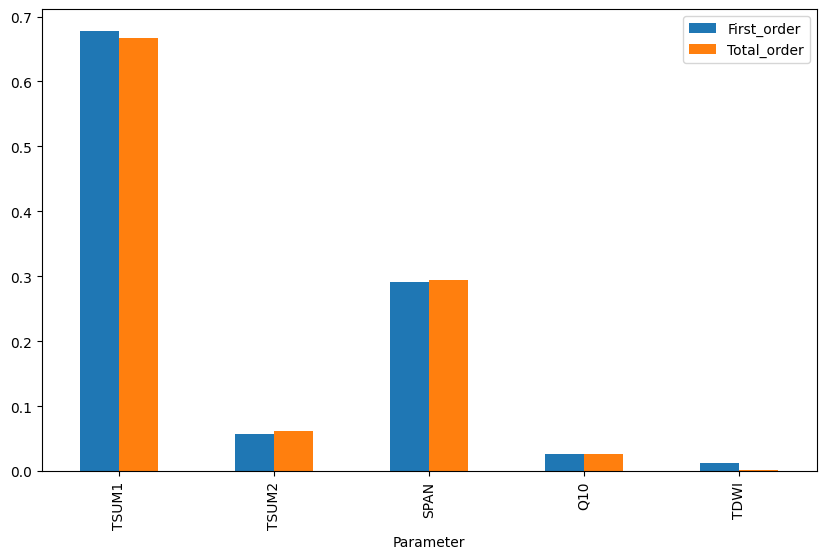

In [10]:
# 创建一个名为df_sensitivity的DataFrame（数据框）对象，用于整理和展示敏感性分析得到的相关结果（参数名称、一阶敏感度和总阶敏感度），方便后续绘图展示。
df_sensitivity = pd.DataFrame({
    "Parameter": problem["names"],
    "First_order": Si["S1"],
    "Total_order": Si["ST"]}).set_index("Parameter")
# 以字典形式构建DataFrame，字典的键作为列名，对应的值作为列数据。
# "Parameter"列的数据来源于之前定义的problem字典中的"names"键对应的值，即敏感性分析涉及的各参数名称列表，用于标识每个参数。
# "First_order"列的数据来自于通过Sobol分析得到的结果字典Si中的"S1"键对应的值，这是各参数的一阶敏感度指数列表，反映每个参数单独变化对目标变量方差的影响占比情况。
# "Total_order"列的数据则取自Si字典中的"ST"键对应的值，代表各参数的总阶敏感度指数列表，体现了考虑参数相互作用等情况下对目标变量总方差的影响程度。
# 最后通过set_index方法将"Parameter"列设置为索引列，使得后续绘图等操作时可以基于参数名称更方便地进行展示和对比。

# 创建一个包含一个子图的图表对象（fig）和对应的坐标轴对象（axes），并设置图表的尺寸大小为宽度10单位、高度6单位，为后续在该坐标轴上绘制柱状图做准备。
fig, axes = plt.subplots(figsize=(10,6))
# plt.subplots函数用于创建子图布局，这里只创建了一个子图，返回的第一个值fig代表整个图表对象，第二个值axes代表这个子图对应的坐标轴对象，可通过该对象设置图表的各种属性、绘制图形等。
# figsize参数用于指定图表的尺寸大小，以元组形式传入宽度和高度的数值，此处设置为(10, 6)，单位通常根据具体使用场景和配置来确定，一般可以理解为相对大小或特定绘图库默认的长度单位。

# 使用前面创建的数据框df_sensitivity，在已获取的坐标轴对象（axes）上绘制柱状图（kind="bar"表示绘制柱状图类型），将各参数对应的一阶敏感度和总阶敏感度以柱状图的形式展示出来，
# 方便直观地对比不同参数的敏感度大小以及一阶和总阶敏感度之间的差异，进而分析参数对目标变量的影响情况和相互作用情况。
df_sensitivity.plot(kind="bar", ax=axes)

## 二阶敏感度
二阶敏感度涉及两个参数的综合敏感度。因此，其结果通过矩阵来可视化呈现最为简便。

In [11]:
# Show second-order sensitivities
# 以下代码用于展示二阶敏感度相关信息。二阶敏感度反映了两个参数相互作用对目标变量产生的影响情况，展示它有助于更全面地了解模型中参数间的复杂关系。

second_order = np.array(Si['S2'])
# 从通过Sobol分析得到的结果字典Si中提取'S2'键对应的值，该值代表二阶敏感度相关的数据（通常是一个多维数组等合适的数据结构，具体取决于分析的参数数量等情况），
# 然后将其转换为NumPy数组形式并赋值给second_order变量，方便后续进行数据处理和展示操作，NumPy数组在数值计算和数据操作方面提供了更高效便捷的功能。

pd.DataFrame(second_order, index=problem["names"], columns=problem["names"])
# 使用pandas库的DataFrame函数，以second_order（二阶敏感度数据）为数据内容创建一个数据框对象。
# 通过index参数指定数据框的行索引为problem字典中"names"键对应的值，也就是敏感性分析涉及的各参数名称列表，使得每行对应一个参数名称。
# 同时，通过columns参数指定列索引同样为problem["names"]，也就是让每列也对应一个参数名称，这样构建出的二维数据框结构，其每个单元格的值代表了对应行和列两个参数相互作用的二阶敏感度数值，
# 方便以表格形式直观地查看和分析不同参数两两组合的二阶敏感度情况，不过这行代码只是创建了数据框，若要完整展示可能还需要进一步的输出或者绘图等操作（比如在Jupyter Notebook环境中直接显示这个数据框等）。

,TSUM1,TSUM2,SPAN,Q10,TDWI
TSUM1,NaN,-0.023497,-0.019199,-0.026210,-0.023213
TSUM2,NaN,NaN,0.020216,0.031330,0.026216
SPAN,NaN,NaN,NaN,-0.022056,-0.025190
Q10,NaN,NaN,NaN,NaN,-0.004923
TDWI,NaN,NaN,NaN,NaN,NaN


或者通过一张图像以图形化方式展示矩阵中的数值。从结果来看，很明显二阶相互作用较小，因为所有指数的值都小于0.1。

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11644\809626419.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  r = aximage.axes.set_yticklabels([""] + problem["names"])


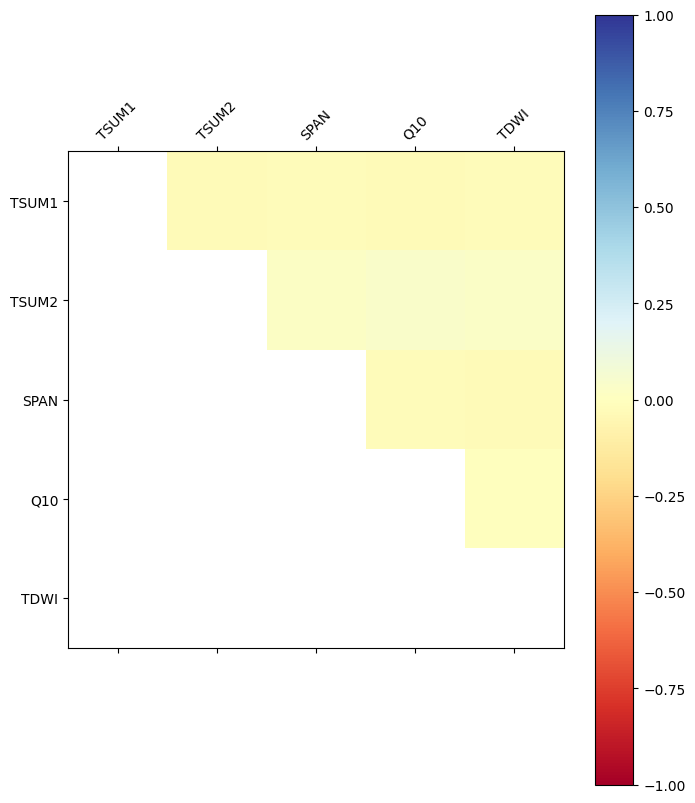

In [12]:
# Visualise second-order sensitivities
# 此行注释说明下面代码的目的是对二阶敏感度进行可视化展示，通过图形的方式呈现二阶敏感度相关数据，以便更直观地观察各参数之间二阶相互作用的情况。

fig, axes = plt.subplots(figsize=(8, 10))
# 使用plt.subplots函数创建一个新的图形（fig）对象以及对应的坐标轴（axes）对象，其中figsize参数设置图形的尺寸大小为宽度8个单位、高度10个单位，
# 这里创建的图形对象和坐标轴对象将作为后续绘制二阶敏感度可视化图形以及添加相关元素（如颜色条、刻度标签等）的基础框架。

aximage = axes.matshow(second_order, vmin=-1.0, vmax=1.0, cmap="RdYlBu")
# 在已获取的坐标轴（axes）上调用matshow函数来展示二阶敏感度数据（second_order，之前已准备好的包含二阶敏感度数值的数组等合适数据结构），
# 通过vmin和vmax参数分别指定颜色映射的最小值为 -1.0，最大值为1.0，这意味着二阶敏感度数值将依据这个范围被映射到对应的颜色上，数值越小颜色越接近vmin对应的颜色，数值越大越接近vmax对应的颜色；
# cmap参数指定使用"RdYlBu"（红-黄-蓝）颜色映射方案，这种颜色映射方式常用于呈现有正负值且需要直观对比大小的数值情况，通过颜色变化可以清晰地看出二阶敏感度数值在不同参数组合下的大小及分布情况，
# 该函数调用返回的aximage对象可用于后续进一步操作这个矩阵可视化图形（比如设置图形属性等）。

cbar = fig.colorbar(aximage)
# 针对前面绘制的二阶敏感度矩阵可视化图形（aximage），在整个图形（fig）对象上添加一个颜色条（colorbar）。颜色条的作用是作为一个可视化的辅助工具，
# 它能清晰地展示出颜色与数值之间的对应关系，使得查看矩阵图时可以根据颜色快速判断出二阶敏感度数值的大致范围，增强可视化展示的可读性和可解释性。

aximage.axes.set_xticks(range(len(problem["names"])))
# 对二阶敏感度矩阵可视化图形（aximage）的x轴进行刻度设置。通过调用set_xticks函数，并传入基于问题参数（problem）中"names"列表长度生成的刻度位置范围（range(len(problem["names"]))），
# 使得x轴上的刻度数量与参与敏感性分析的参数个数保持一致，为下一步正确添加参数名称作为x轴刻度标签做准备，确保每个参数都能有对应的刻度位置来显示其标签。

aximage.axes.set_xticklabels(problem["names"], rotation=45)
# 为二阶敏感度矩阵可视化图形（aximage）的x轴刻度添加对应的标签。将问题参数（problem）中"names"里的各个参数名称作为标签内容（这样每个刻度位置就能对应一个具体的参数），
# 同时设置标签旋转45度，这样做是为了避免由于参数名称可能较长而在x轴上产生标签文字相互重叠的情况，保证每个参数名称都能清晰地展示出来，方便查看和将可视化图形与实际的参数对应起来。

r = aximage.axes.set_yticklabels([""] + problem["names"])
# 为二阶敏感度矩阵可视化图形（aximage）的y轴刻度设置标签。先将一个空字符串添加到问题参数（problem）中"names"列表的开头，然后以此列表作为y轴刻度标签进行设置，
# 这样做的目的可能是出于可视化布局或者与矩阵数据行列对应关系等方面的考虑，使得y轴标签与二阶敏感度矩阵数据的展示逻辑更加契合，便于直观地观察和解读不同参数之间的二阶敏感度情况，
# 该操作返回的r变量可能包含了此次设置y轴刻度标签操作的一些相关结果信息（具体取决于函数内部实现机制），不过通常在这个场景下可能并不一定需要直接使用这个返回值。

## 解释
甜菜产量对有效积温（TSUM1）敏感的背景与以下事实相关：较大的有效积温（TSUM1）意味着作物将在营养生长阶段停留更长时间。鉴于收获日期是固定的，这就意味着甜菜根积累糖分的可用时间会缩短，因此模拟得出的产量就会更低。显然，分析中涉及的其他参数在所选定的取值范围内并没有产生很大影响，所以就敏感度而言，有效积温（TSUM1）相较于其他参数占主导地位。 

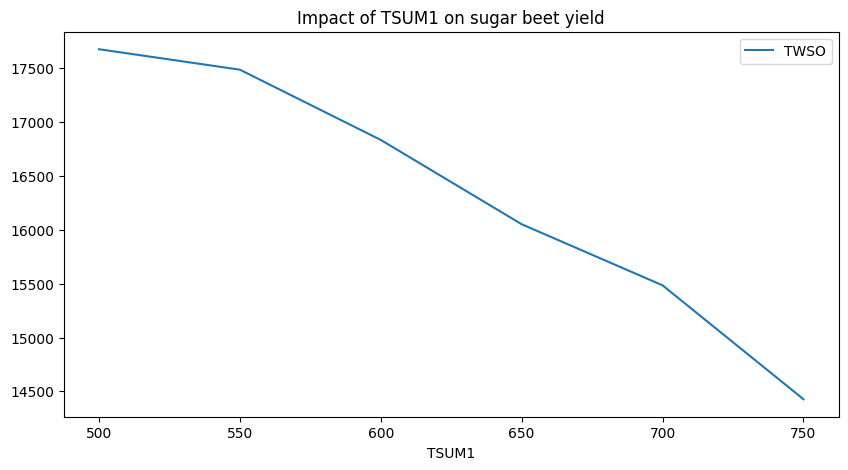

In [13]:
TSUM1_values = list(range(500, 800, 50))
# 创建一个名为TSUM1_values的列表，通过使用range函数生成一个从500到799（不包含800，因为range函数的特性是左闭右开区间）、步长为50的整数序列，
# 并将其转换为列表形式。这个列表中的值将作为TSUM1参数后续要设置的不同取值，用于单独探究该参数变化对甜菜产量的影响。

results = []
# 创建一个空列表results，用于存储在不同TSUM1取值下运行模型后得到的目标变量（即甜菜产量相关指标，由前面定义的target_variable指定）的结果，方便后续整理和分析数据。

for tsum1 in TSUM1_values:
    # 开始对TSUM1_values列表进行循环遍历，每次循环取出一个TSUM1的取值（tsum1变量），用于设置模型参数并运行模型，观察对应的产量结果变化。
    params.clear_override()
    # 调用params对象（应该是与模型参数管理相关的对象，比如之前提到的ParameterProvider类的实例等）的clear_override方法，
    # 清除之前可能设置的所有参数覆盖值，确保每次循环时参数处于初始干净的状态，避免之前的设置对本次循环产生干扰。

    params.set_override("TSUM1", tsum1)
    # 使用params对象的set_override方法，将名为"TSUM1"的参数设置为当前循环中取出的tsum1值，也就是依次将TSUM1参数设置为TSUM1_values列表中的不同取值，
    # 以此来单独考察该参数变化对模型结果（甜菜产量）的影响情况。

    wofost = Wofost72_PP(params, wdp, agro)
    # 使用更新后的参数（params）、气象数据提供者（wdp）以及农业管理信息（agro）实例化一个WOFOST 72_PP模型对象wofost，准备运行该模型实例，
    # 以模拟在当前TSUM1参数取值下的甜菜生长情况，进而获取对应的产量结果。

    wofost.run_till_terminate()
    # 调用wofost对象的run_till_terminate方法，运行WOFOST模型直到满足终止条件，这个过程中模型会根据设定的参数、气象数据以及农业管理情况模拟甜菜从开始到结束的整个生长过程，
    # 最终得到相应的模拟结果。

    r = wofost.get_summary_output()
    # 调用wofost对象的get_summary_output方法，获取模型运行结束后的汇总输出结果，这个结果可能包含了多个与甜菜生长相关的指标信息，以某种数据结构（比如字典、列表嵌套等形式）返回。

    results.append(r[0][target_variable])
    # 从模型的汇总输出结果（r）中提取出目标变量（target_variable，之前定义的与甜菜产量相关的那个变量）的值，这里假设r的结构中第一层索引为0（具体结构需结合模型实际返回情况确定），
    # 然后将该值添加到results列表中，不断积累不同TSUM1取值下对应的甜菜产量结果，为后续的数据分析和可视化展示做准备。

df = pd.DataFrame({"TSUM1": TSUM1_values,
                   target_variable: results}
                 ).set_index("TSUM1")
# 使用pandas库的DataFrame函数创建一个数据框（df）对象，以字典形式传入数据，字典的键作为列名，对应的值作为列数据。
# 其中"TSUM1"列的数据就是前面生成的TSUM1参数的不同取值列表（TSUM1_values），另一列使用之前定义的目标变量名（target_variable）作为列名，对应的数据是之前循环收集到的不同TSUM1取值下的甜菜产量结果列表（results），
# 最后通过set_index方法将"TSUM1"列设置为索引列，方便后续基于TSUM1取值来查看和分析对应的甜菜产量情况，例如绘制图表时可以以TSUM1为横坐标进行展示。

r = df.plot(title="Impact of TSUM1 on sugar beet yield", figsize=(10,5))
# 调用数据框（df）对象的plot方法，绘制图表来展示TSUM1参数变化对甜菜产量的影响情况。通过title参数设置图表的标题为"Impact of TSUM1 on sugar beet yield"（表明展示的是TSUM1对甜菜产量的影响），
# 并使用figsize参数设置图表的尺寸大小为宽度10单位、高度5单位，绘制完成后返回的结果（通常包含绘图相关的一些信息，具体取决于绘图函数实现细节）赋值给变量r，
# 这样可以在合适的环境（比如Jupyter Notebook等）中展示出绘制好的图表，直观地呈现出TSUM1与甜菜产量之间的关系。

# 加速样本模拟
当要对许多变量进行敏感性评估时，遍历样本很快就会变成一个漫长的过程。不过，由于对每个样本的模拟都是相互独立的，我们可以通过在多个中央处理器（CPU）上运行来轻松加快模拟速度。Python提供了“multiprocessing”（多进程）模块，用于启动一组工作进程来执行模拟任务。

在Jupyter Notebook中演示“multiprocessing”模块的使用是比较复杂的，因为Notebook的基础架构并不支持它。因此，我们提供了一个独立的Python脚本，该脚本使用顺序处理和并行处理执行的计算与本Notebook中的计算完全相同。可以从[此处](SA_mp_example.py)下载该脚本。 